# ch04.08 Transformer

* 날짜:
* 이름:

## 학습내용
  - Transformer을 이해하고 구현한다.
  - Vision Transformer을 이해하고 구현한다.

## 참고 사이트

   - 논문 [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys, os
sys.path.append('/content/drive/MyDrive/script/')
from lib import *

## 모듈 제작
---

### **| Multi Head Attention**

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-09.PNG?raw=true?raw=true?raw=true
 width=350>
</p>

* set params

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-01.PNG?raw=true?raw=true
 width=850>
</p>


In [3]:
h = 8
d_k = 64
d_v = 64
d_model = 512   # h * 64 = dembedding dims

# 인풋 X.shape 
# 시계열 : ( time range(window_size), channel )
# 텍스트 : (max lenth, vocab size(embedding))
# X가 세가지로 나뉘는 것 -> V, K, Q
# T = S = max lenth
# d_model = embedding dims
T = 200
S = 100

Q = (T, d_model)
K = (S, d_model)
V = (S, d_model)

print(Q)
print(K)
print(V)


(200, 512)
(100, 512)
(100, 512)


In [4]:
def matmul(shape1, shape2):
  assert shape1[1]==shape2[0]
  return (shape1[0], shape2[1])


* Step1. Linear each  $Q, K, V(W^Q, W^K, W^V)$

<br>

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-05.PNG?raw=true?raw=true?raw=true
 width=250>
</p>

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-02-1.PNG?raw=true?raw=true
 width=850>
</p>



In [5]:
# set weights
W_Q = (d_model, d_k)
W_K = (d_model, d_k)
W_V = (d_model, d_k)

# calculate shape
VW = matmul(V, W_V)
KW = matmul(K, W_K)
QW = matmul(Q, W_Q)

print(f'Q {Q} x W_Q {W_Q} = {VW}')
print(f'K {K} x W_K {W_K} = {KW}')
print(f'V {V} x W_V {W_V} = {QW}')

Q (200, 512) x W_Q (512, 64) = (100, 64)
K (100, 512) x W_K (512, 64) = (100, 64)
V (100, 512) x W_V (512, 64) = (200, 64)


* Step2. Attention


<p align='center'>
<img src=https://wikidocs.net/images/page/159310/mha_img_original.png?raw=true
 width=450>
</p>


<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-03.PNG?raw=true?raw=true
 width=850>
</p>

In [6]:
KW_T = (KW[1], KW[0])
print(f"QW: {QW}, KW_T: {KW}, VW: {VW}")

Att = matmul(matmul(QW, KW_T), VW)
print(f'Attention(QW, KW, VW) : {Att}')

QW: (200, 64), KW_T: (100, 64), VW: (100, 64)
Attention(QW, KW, VW) : (200, 64)


* step3. concat & Linear $(W^O)$

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-10.PNG?raw=true?raw=true?raw=true
 width=300>
</p>

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-04.PNG?raw=true?raw=true
 width=850>
</p>

In [7]:
print(f'- Attention(QW, KW, VW) = head {Att}')

concat_att = (Att[0], Att[1]*h)

print(f'- Concat(head_1, ...head_h)')

W_O = ((h*d_v), d_model)
final_out = matmul(concat_att, W_O)
print(f'- Concat {concat_att}x W_O {W_O}  = final output {final_out}' )

- Attention(QW, KW, VW) = head (200, 64)
- Concat(head_1, ...head_h)
- Concat (200, 512)x W_O (512, 512)  = final output (200, 512)


In [8]:
print('- 인풋: ',  V, K, Q)
print(f'- 최종 아웃풋: {final_out}')

- 인풋:  (100, 512) (100, 512) (200, 512)
- 최종 아웃풋: (200, 512)


#### Tensorflow.keras MultiHeadAttention Layer

* docs: https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention

```
tf.keras.layers.MultiHeadAttention(
    num_heads,
    key_dim,
    value_dim=None,
)

# call args

query	Query Tensor of shape (B, T, dim).
value	Value Tensor of shape (B, S, dim).
key	Optional key Tensor of shape (B, S, dim). If not given, will use 
```

In [9]:
#X = layers.Input(shape=()) # (max_lenth, embdding dims)

Q = layers.Input(shape=(T, d_model))  
K = V = layers.Input(shape=(S, d_model))  
y = layers.MultiHeadAttention(8, 64, 64)(Q, K, V) # V 만 써줘도됨 같기때문에

In [10]:
print(f'- 인풋: V {V.shape} K {K.shape} Q {Q.shape}')
print(f'- 최종 아웃풋: {y.shape}')

- 인풋: V (None, 100, 512) K (None, 100, 512) Q (None, 200, 512)
- 최종 아웃풋: (None, 200, 512)


### **| Encoder Block**

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-11.PNG?raw=true?raw=true
 width=250>
</p>

In [11]:
def encoder_block(Input_shape, h, d_k, d_ff, dropout=0.25, name=None):

  inputs = layers.Input(shape=Input_shape)

  # Attention and Normalization
    # multi=head
  y = layers.MultiHeadAttention(8, 64, dropout=dropout)(inputs, inputs) # 멀티헤드 어텐션 안에 있는 리니어 드롭아웃 
  y = layers.Dropout(dropout)(y)

    # ADD & Norm
  y = layers.LayerNormalization(epsilon=1e-6)(y)
  y_1 = layers.Add()([y, inputs])

  # Feed Forward Part
    # FF
  y = layers.Conv1D(filters=d_ff, kernel_size=1, activation='relu')(y_1)   # d_ff에따라 줄어듬
  y = layers.Dropout(dropout)(y)
  y = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1, activation='relu')(y)
    # Add & Norm
  y = layers.LayerNormalization(epsilon=1e-6)(y)
  outputs = layers.Add()([y, y_1])

  return models.Model(inputs, outputs, name=name)



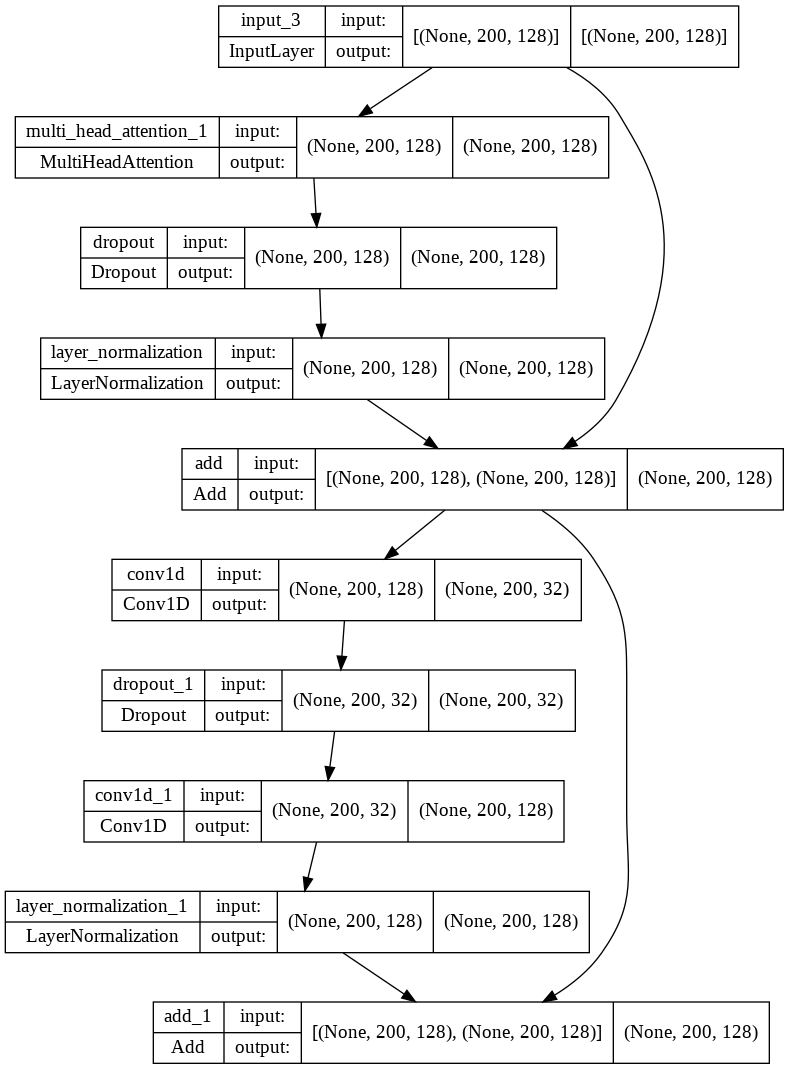

In [12]:
input_shape = (200, 128)
h = 8
d_k = 256
d_ff = 32
encoder = encoder_block(input_shape, h, d_k, d_ff)
utils.plot_model(encoder, show_shapes=True)

## 실습1. 시계열 데이터 분류
---

### **| 시계열 데이터셋**

In [13]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

n_classes = len(np.unique(y_train))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

(3601, 500, 1) (3601,)


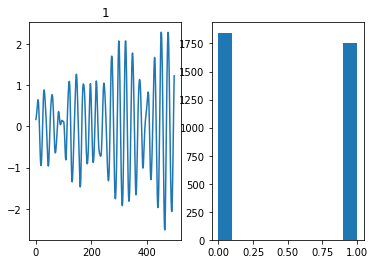

In [14]:
print(x_train.shape, y_train.shape)

idx = 10
plt.subplot(121)
plt.title(y_train[idx])
plt.plot(x_train[idx])
plt.subplot(122)
plt.hist(y_train)
plt.show()



### **| 모델 구현**

In [15]:
# Set params
input_shape = (500,1) # (T/S, d_model)
n_classes=2

h = 4
d_k = 128
d_ff= 4

# 모델 구현

# Set Input
inputs = layers.Input(shape=input_shape)




# Encoder Block
y = inputs
for i in range(h):
  encoder = encoder_block(input_shape, h, d_k, d_ff, name=f'encoder_{i}')
  y = encoder(inputs)




# Classifier
y = layers.GlobalAveragePooling1D(data_format='channels_first')(y)  # flatten 하듯이
y = layers.Dense(128, activation='relu')(y)
y = layers.Dropout(0.5)(y)
y = layers.Dense(n_classes, activation='softmax')(y)



# Final model
model = models.Model(inputs, y, name='TranseformerEncoderCfy')
model.summary()

Model: "TranseformerEncoderCfy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 500, 1)]          0         
                                                                 
 encoder_3 (Functional)      (None, 500, 1)            3602      
                                                                 
 global_average_pooling1d (G  (None, 500)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 128)               64128     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                            

In [16]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics='acc')
es = tf.keras.callbacks.EarlyStopping(patience=0, restore_best_weights=True)
model.fit(x_train, y_train, validation_data=[x_test, y_test],
          epochs=50,
          batch_size=54,
          callbacks=es)

Epoch 1/50
67/67 [==============================] - 17s 69ms/step - loss: 1.0546 - acc: 0.5151 - val_loss: 0.7435 - val_acc: 0.5644
Epoch 2/50
67/67 [==============================] - 4s 65ms/step - loss: 0.9115 - acc: 0.5568 - val_loss: 0.6666 - val_acc: 0.6152


## 실습2. IMDB 텍스트 분류
---

### **| IMDB 데이터셋**


In [17]:
vocab_size = 20000  
maxlen = 200  

(x_train, y_train), (x_val, y_val) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)
print(x_train.shape, x_val.shape)

17473536/17464789 [==============================] - 0s 0us/step
25000 Training sequences
25000 Validation sequences
(25000, 200) (25000, 200)


In [19]:
vocab_size = 20000  
maxlen = 200 
embed_dim = 128


x = layers.Input(shape=(maxlen, ))
x_em = layers.Embedding(input_dim= vocab_size,
                        output_dim = embed_dim)(x)
print(x.shape, x_em.shape)                        

(None, 200) (None, 200, 128)


In [20]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__() # 부모 클래스의 초기값들을 가져오기
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [21]:
embed = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)


### **| 모델 구현**

In [22]:
# Set params
maxlen=200
vocab_size=20000
embed_dim=32

n_classes=2

h = 4
d_k = 32
d_ff= 32

# 모델 구현

# Set Input
inputs = layers.Input(shape=(maxlen,))

# Embedding :  (maxlen) -> (maxlen, embed_dim)

y_emb = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)(inputs)



# Encoder Block
y = y_emb
for i in range(h):
  encoder = encoder_block(y.shape[1:], h, d_k, d_ff, name=f'encoder_{i}')
  y = encoder(y)




# Classifier
y = layers.GlobalAveragePooling1D(data_format='channels_first')(y)  # flatten 하듯이
y = layers.Dense(128, activation='relu')(y)
y = layers.Dropout(0.5)(y)
y = layers.Dense(n_classes, activation='softmax')(y)



# Final model
model = models.Model(inputs, y, name='TranseformerEncoderCfy')
model.summary()

Model: "TranseformerEncoderCfy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 200)]             0         
                                                                 
 token_and_position_embeddin  (None, 200, 32)          646400    
 g_1 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 encoder_0 (Functional)      (None, 200, 32)           69344     
                                                                 
 encoder_1 (Functional)      (None, 200, 32)           69344     
                                                                 
 encoder_2 (Functional)      (None, 200, 32)           69344     
                                                                 
 encoder_3 (Functional)      (None, 200, 32)

### **| 학습**

In [23]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics='acc')
es = tf.keras.callbacks.EarlyStopping(patience=0, restore_best_weights=True)
model.fit(x_train, y_train, validation_data=[x_val, y_val],
          epochs=50,
          batch_size=54,
          callbacks=es)

Epoch 1/50
463/463 [==============================] - 43s 85ms/step - loss: 0.6932 - acc: 0.5052 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/50
463/463 [==============================] - 39s 84ms/step - loss: 0.6923 - acc: 0.5215 - val_loss: 0.6850 - val_acc: 0.5743


## 실습3. Vision Transformer
---

In [ ]:
def display_img_patches(img, patches):

  # origin image


  # patches

  # real patches


### **| 이미지 증강**

### **| Patch 생성**

### **| Patch Encoder**


### **| 모델 구현**

In [ ]:
# Set params


# Set Input

# Encoder Block


# Classifier

# Final model
